# **Progetto Deblur**

---

Un'azienda vuole commercializzare un dispositivo di acquisizione immagini, del quale si sa che acquisisce con rumore Gaussiano additivo e sfocatura Gaussiana.
Il modello è quindi:

\begin{align*}
    b = A x_{true} + \eta
\end{align*}

Dove $A \in \mathbb{R}^{mn}$ è la matrice di sfocamento, $\eta \sim \mathcal{N}(0, \sigma^2)$ rumore additivo con varianza $\sigma^2$ incognita, $b \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine corrotta (acquisita) $B \in \mathbb{R}^{m \times n}$, $x_{true} \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine originale $X_{true} \in \mathbb{R}^{m \times n}$.


1. Dopo aver importato le librerie necessarie, assegnare ad una variabile $X$ l'immagine $\texttt{cameraman}$, ottenibile tramite la libreria $\texttt{skimage.data}$ con il nome di $\texttt{camera()}$, effettuarne il $\texttt{reshape}$ e assegnarlo alla variabile $x$.

2. Tramite la funzione $\texttt{skimage.filters.gaussian}$ aggiungere sfocatura Gaussiana ad $X$ per ottenere $X_{blur}$, che rappresenta il reshape ad immagine di $x_{blur} = A x_{true}$, con $A$ matrice di sfocatura.

3. Caricare su una variabile $\eta$, della stessa dimensione di $X_{true}$, una realizzazione di rumore gaussiano con varianza $\sigma = 0.1$ (fare riferimento alle slides per la formula). 
Utilizzare $\eta$ per corrompere l'immagine $X_{blur}$ e calcolare $B = X_{blur} + \eta$. \\
Visualizzare i risultati ottenuti.

In [1]:
#Ilaria Palestini, Kusamdevi Lal, Simone Sanna

def gkern(kernlen, nsig): 
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """
  import scipy.stats as st

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d/kern2d.sum()

def A(x, d=7, sigma=0.5):                 #K immagine della PFS (A)
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata). 
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K = gkern(d, sigma)
  K_ext[:d, :d] = K
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

def AT(x, d=7, sigma=0.5):
  """
  Esegue il prodotto A^T x, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(np.conj(K_ext) * x))

512 512


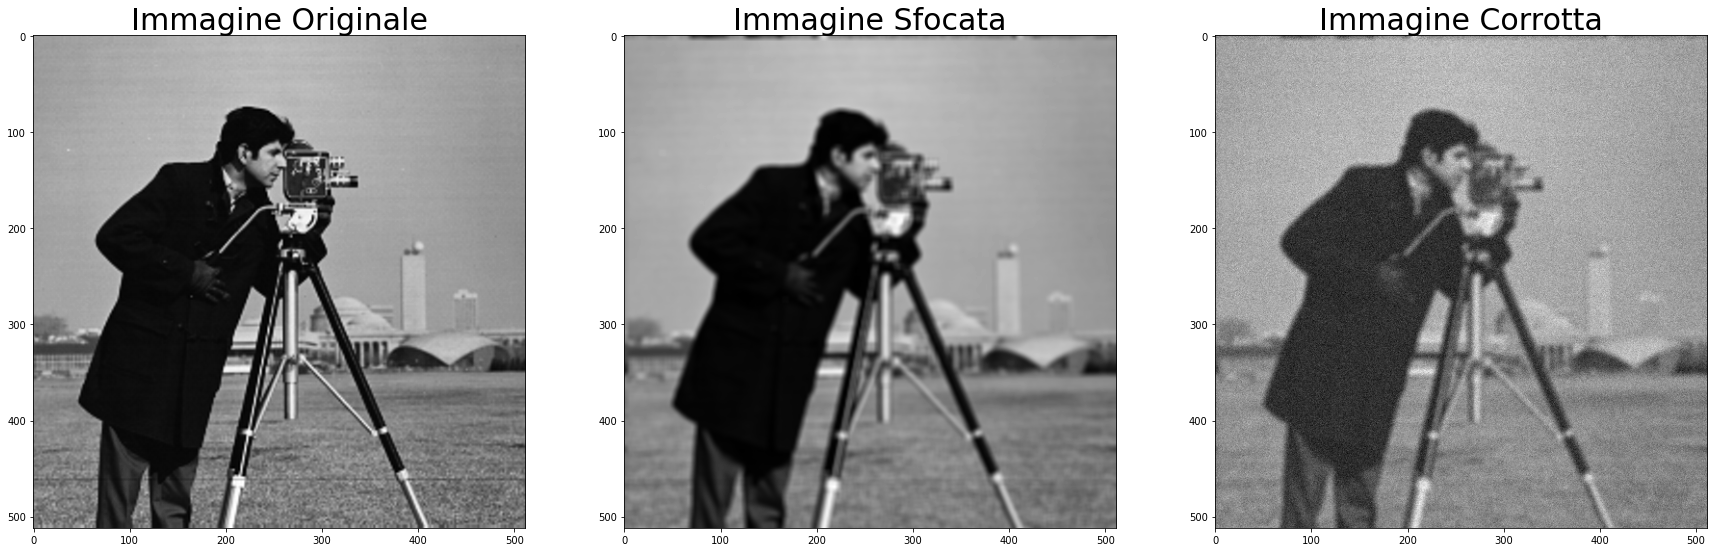

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, color
from PIL import Image 

#X = data.checkerboard()                                                        #Immagine di scacchiera
#X = color.rgb2gray(data.astronaut())                                            #Astronauta
#X = data.shepp_logan_phantom()                                                
#X = data.text()

# 1
X = data.camera()                                                               #immagine originale, f_exact
m, n = X.shape                                                                  #dimensioni dell'immagine originale
x = X.reshape(m*n)                                                              #vettorizzazione della matrice X (ovvero dell'immagine originale)

print(m,n)
# 2
X_blur = A(X)                                                                   #Immagine originale, sfocata, g_blur
x_blur = X_blur.reshape(m*n)                                                    #Immagine originale, sfocata e vettorizzata


# 3
# Generiamo il rumore eta
sigma = 0.1                                                                     #Varianza del rumore
eta = np.random.normal(size=X_blur.shape)
eta /= np.linalg.norm(eta, 'fro')
eta *= sigma * np.linalg.norm(X_blur,'fro')                                     #array rumore W (512 x 512)

# Aggiungiamo il rumore all'immagine sfocata
B = X_blur + eta                                                                #Immagine sfocata e con rumore, g
b = B.reshape(m*n)                                                              #Immagine sfocata e con rumore, vettorizzata

# Visualizziamo i risultati
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

plt.show()

Il problema di ricostruire l'immagine originale partendo dalla sua corruzione $b$, si può riscrivere come un problema di ottimizzazione

\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 \hspace{2cm} (1)
\end{align}

4. Risolvere il problema (1) utilizzando l'algoritmo di discesa del gradiente con scelta del passo tramite backtracking, ricordando che, se 
\begin{align*}
  f(x) = \frac{1}{2} ||Ax - b||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b)
\end{align*}
E chiamare la soluzione ottenuta $x_{naive}$.

5. Modificare l'algoritmo precedente a far restituire l'errore tra l'immagine ricostruita al passo $k$ e l'immagine originale, per ogni $k$. Visualizzare il grafico dell'errore, e individuare per quale valore di $k$ si ha semiconvergenza. Per tale valore, calcolare l'immagine ricostruita e chiamarla $x_{trunc}$.

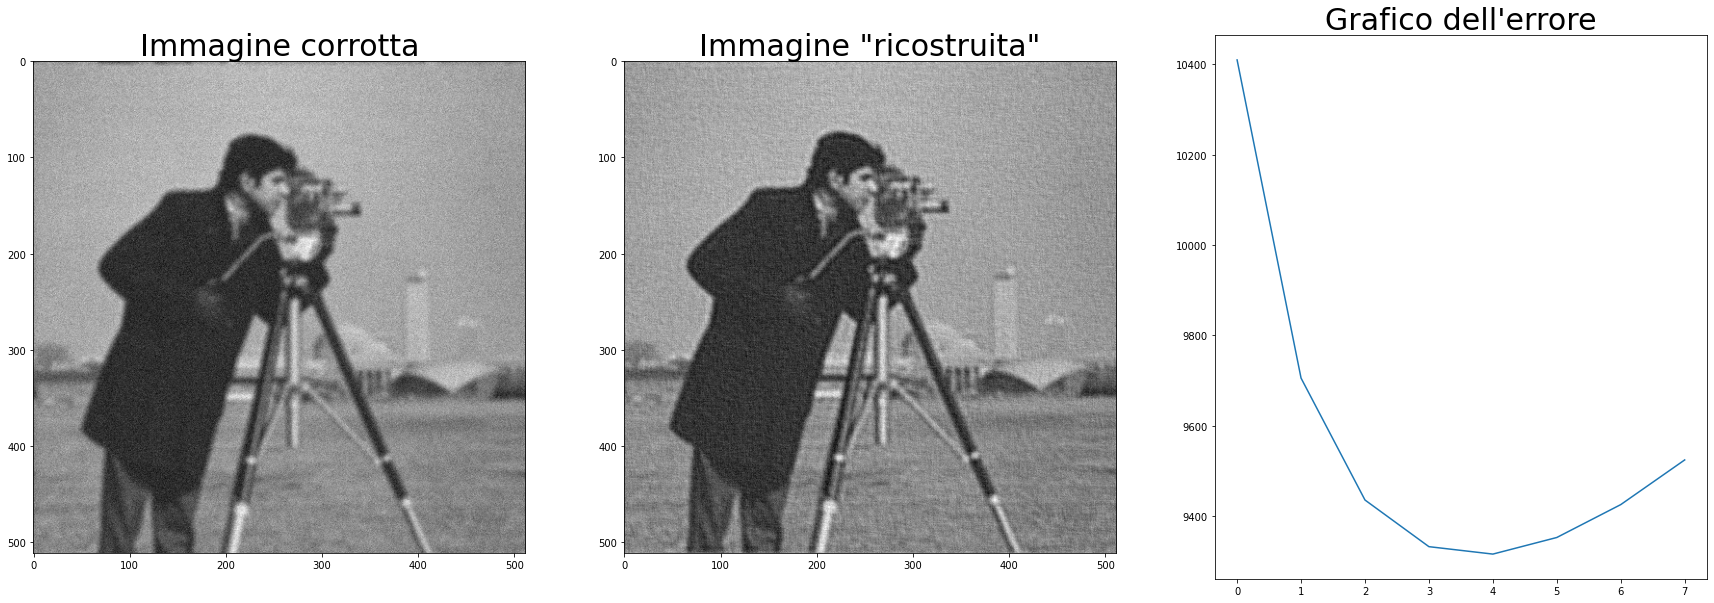

In [3]:
# x* è l'immagine che ricostruiamo noi
# A è la matrice di blur
#b è l'immagine corrotta
#dim di X, B, A(X), gradf = (512, 512)
#x0, x1 coordinate del punto iniziale
eps = 1.e-5
from skimage import data, filters
maxit = 8

def gradf(X,B):                                                                 #GRADIENTE di f(x)
  return AT(A(X) - B)                                                           

def f(X,B):                                                                     #definisco f(x,b)
  return ((1/2)*(np.linalg.norm(A(X)-B,'fro'))**2)

def next_step(x,b,grad):                                                        #backtracking per la scelta del passo
  alpha=1.1
  c1 =0.25
  while (f(x-alpha*grad, b)> f(x,b)- alpha*c1*np.linalg.norm(grad,'fro')):
      alpha = alpha*c1                                                          #aggiorno alpha
  return alpha

def discesa(x0, B, maxit):
  alpha = next_step(x0, B, gradf(x0, B))

k = 0  
x0 = B                                                                          #prendo B come matrice iniziale
err_y = np.zeros(maxit)

while ( (k < maxit) and np.linalg.norm(gradf(x0,B) < eps) and (np.linalg.norm(gradf(x0, B), 2)!=0) ):                     #controllare le condizioni
  #print(k)
  alpha = next_step(x0, B, gradf(x0,B))                                         #calcolo il passo successivo
  x1 = x0 - alpha * gradf(x0, B)                                                #calcolo x[k+1]
  err_y[k] = np.linalg.norm(X - x1, 'fro')
  k = k + 1                                                                     #incremento il contatore
  x0 = x1                                                                       #aggiorno l'immagine

#Stampo i risultati

plt.figure(figsize=(30, 10)) 

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(B, cmap='gray')
plt.title('Immagine corrotta', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(x1, cmap='gray')
plt.title('Immagine "ricostruita"', fontsize=30)

err_x = np.linspace(0, maxit - 1, maxit)
ax3 = plt.subplot(1, 3, 3)
plt.plot(err_x, err_y)
plt.title("Grafico dell'errore", fontsize=30)

err_x1 = err_x
err_y1 = err_y

x_trunc = x1
X_Naive = x1

plt.show()

# Per risolvere la semiconvergenza, si introduce il problema regolarizzato

\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 \hspace{2cm} (2)
\end{align*}

con $\lambda > 0$ parametro di regolarizzazione.

6. Sfruttando il fatto che, se
\begin{align*}
f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b) + \lambda x
\end{align*}
Risolvere il problema (2) utilizzando l'algoritmo precedente per diversi valori di $\lambda$, e stimare il valore ottimale di $\lambda$ che minimizzi l'errore tra l'immagine ricostruita e l'immagine originale (metodo euristico per il parametro di regolarizzazione). Chiamare $x_{\lambda}$ tale soluzione. \\

7. Stimare il valore ottimale di $\lambda$ tramite principio di discrepanza, ovvero scegliere il più grande $\lambda$ tale che
\begin{align*}
  ||A x_\lambda - b||_2^2 \leq ||\eta||_2^2
\end{align*}
Dove $\eta$ è il rumore. Chiamare $x_\lambda^{disc}$ la soluzione ottenuta dal $\lambda$ calcolato con principio di discrepanza.
 

[31254.69923581 34244.82048762 35521.60058543 36067.12571295
 36300.85816611 36401.44954081 36445.02051095 36464.06455917
 36497.78843502 36487.67466314]


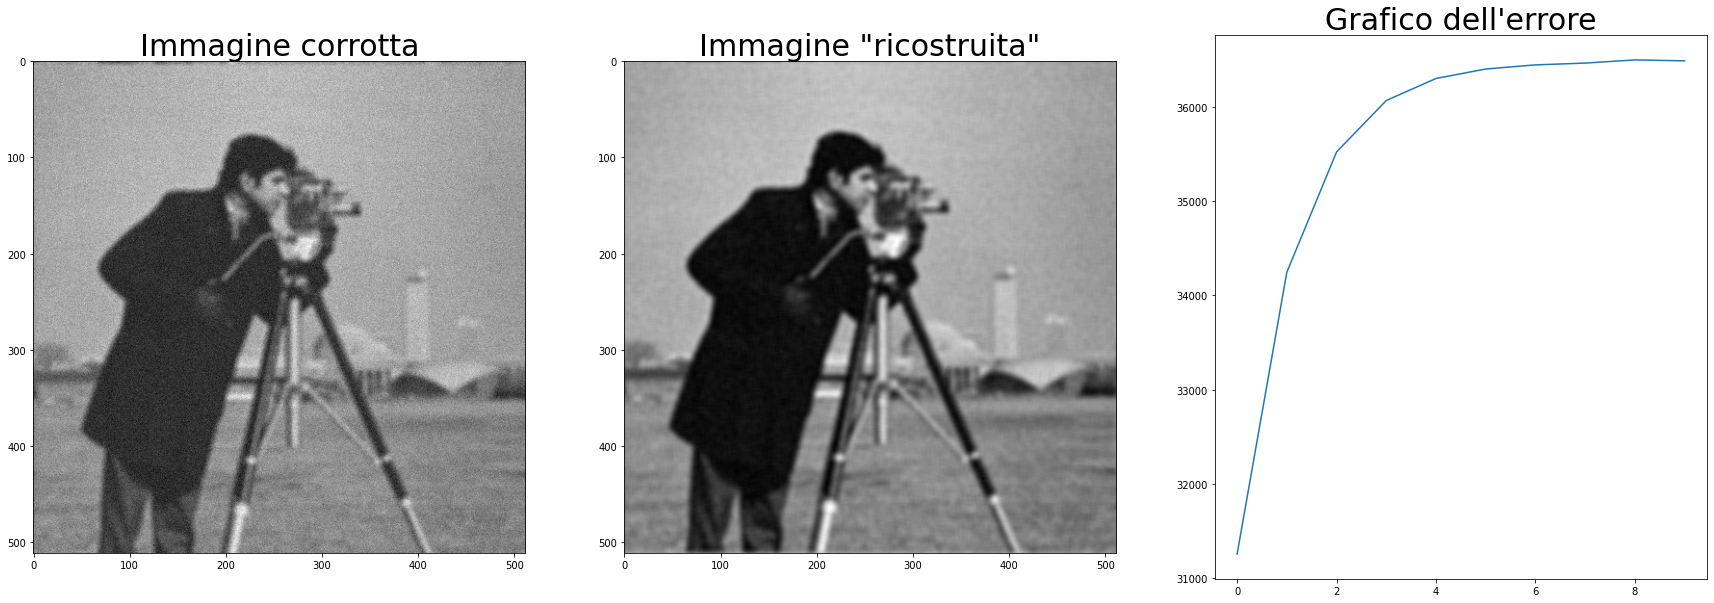

In [4]:
lambda_ = 0.005
maxit = 10
x_lambda = x_trunc
def gradf(X,B, L):                                                                 #GRADIENTE di f(x)
  return ( AT(A(X) - B) + L * X )                                                        

def f(X,B, L):                                                                     #definisco f(x,b)
  return ( ((1/2)*(np.linalg.norm(A(X)-B,'fro'))**2) + (L / 2) * np.linalg.norm(X, 'fro')**2 )

def next_step(x,b,grad, L):                                                        #backtracking per la scelta del passo
  alpha=1.1
  c1 =0.25
  while (f(x-alpha*grad, b, L)> f(x,b,L)- alpha*c1*np.linalg.norm(grad,'fro')):
      alpha = alpha*c1                                                          #aggiorno alpha
  return alpha

def discesa(x0, B, L, maxit):
  alpha = next_step(x0, B, gradf(x0, B, L), L)

k = 0  
k1 = 0
x0 = B    
lam = 0
err_y = np.zeros(maxit)
while ( ( ((np.linalg.norm(A(x_lambda)-B, 'fro'))**2) != ( (np.linalg.norm(eta, 'fro'))**2 )) and (lam <1) ):

  lam = lam + 0.1 
  #print(lam)

  k=0
  while ( (k < maxit) and np.linalg.norm(gradf(x0,B, lam) < eps) and (np.linalg.norm(gradf(x0, B, lam), 2)!=0) ):
    alpha = next_step(x0, B, gradf(x0,B, lam), lam)                                        
    x1 = x0 - alpha * gradf(x0, B, lam)                                               
    err_y[k] = np.linalg.norm(np.subtract(X,x1), 'fro')
    k = k + 1                                                                    
    x0 = x1 
  if(k>2):
    k1 = k
  x_lambda = x1 

print(err_y)
err_y = err_y[0:k1]
err_x = np.linspace(0, k1 - 1, k1)

x_lambda = x1

err_x2 = err_x
err_y2 = err_y

#Stampo i risultati
lam = 0

plt.figure(figsize=(30, 10)) 

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(B, cmap='gray')
plt.title('Immagine corrotta', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(x_lambda, cmap='gray')
plt.title('Immagine "ricostruita"', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
plt.plot(err_x, err_y)
plt.yscale('linear')
plt.title("Grafico dell'errore", fontsize=30)



plt.show()



```
# Questo è formattato come codice
```

8. Ripetere quanto fatto nel punto 6, utilizzando la norma 1 come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda ||x||_1 \hspace{2cm} (3)
\end{align*}
Dove la funzione obiettivo ha gradiente
\begin{align*}
  A^T(Ax - b) + \lambda \hspace{2px} sign(x)
\end{align*}

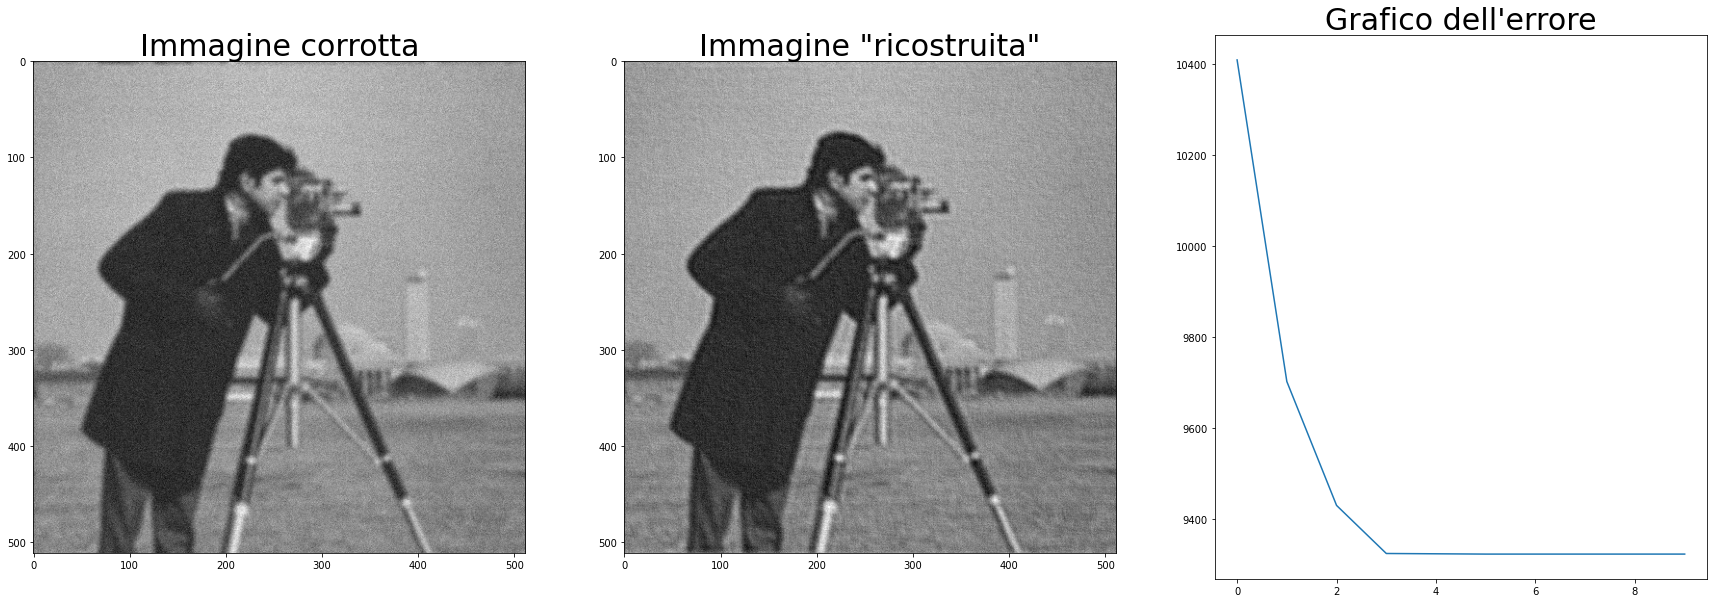

In [5]:
lambda_ = 0.05
maxit = 10

def gradf(X,B):                                                                 #GRADIENTE di f(x)
  return ( AT(A(X) - B) + lambda_ * np.sign( X ) )                                                        

def f(X,B):                                                                     #definisco f(x,b)
  return ( ((1/2)*(np.linalg.norm(A(X)-B,'fro'))**2) + (lambda_ / 2) * np.linalg.norm(X, 1)**2 )

def next_step(x,b,grad):                                                        #backtracking per la scelta del passo
  alpha=1.1
  c1 =0.25
  while (f(x-alpha*grad, b)> f(x,b)- alpha*c1*np.linalg.norm(grad,'fro')):
      alpha = alpha*c1                                                          #aggiorno alpha
  return alpha

def discesa(x0, B, maxit):
  alpha = next_step(x0, B, gradf(x0, B))

k = 0  
x0 = B                                                                           #prendo B come matrice iniziale
err_y = np.zeros(maxit)

while ( (k < maxit) and np.linalg.norm(gradf(x0,B) < eps) and (np.linalg.norm(gradf(x0, B), 2)!=0) ):
#  print(k)
  alpha = next_step(x0, B, gradf(x0,B))                                         #calcolo il passo successivo
  x1 = x0 - alpha * gradf(x0, B)                                                #calcolo x[k+1]
  err_y[k] = np.linalg.norm(X-x1, 'fro')
  k = k + 1                                                                     #incremento il contatore
  x0 = x1                                                                       #aggiorno l'immagine

err_y = err_y[0:k]

err_x = np.linspace(0, k - 1, k)

err_x3 = err_x
err_y3 = err_y

#Stampo i risultati

plt.figure(figsize=(30,10)) 

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(B, cmap='gray')
plt.title('Immagine corrotta', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(x1, cmap='gray')
plt.title('Immagine "ricostruita"', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.plot(err_x, err_y)
plt.yscale('linear')

plt.title("Grafico dell'errore", fontsize=30)

x_trunc2 = x1
plt.show()

9. ($\textit{facoltativo}$) Ripetere quanto fatto nei punti 6 e 8, utilizzando una norma mista come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 + \mu ||x||_1 \hspace{2cm} (4)
\end{align*}

# ---

# Analisi dei risultati

---

Per ognuna delle soluzioni trovate, calcolare:

*   Errore relativo rispetto alla soluzione esatta $x_{true}$.
*   PSNR (Peak Signal to Noise Ratio).

Visualizzare le ricostruzioni ottenute con i vari metodi, e confrontare, sia numericamente che attraverso dei grafici, PSNR ed errore relativo ottenuti dalle ricostruzioni. Includere nel confronto, il valore delle metriche per l'immagine corrotta $b$.


In [6]:
#Funzione PSNR

import math
import cv2
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
      return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

Gli errori sono:
  X_Naive  9524.604903998554 
  x_lambda  36487.67466314466 
  x_trunc  9323.1115943889 


I valori dei PSNR sono:
  X_Naive  22.739263438506782 
  x_lambda  11.073279089619499 
  x_trunc  22.924985176091937 




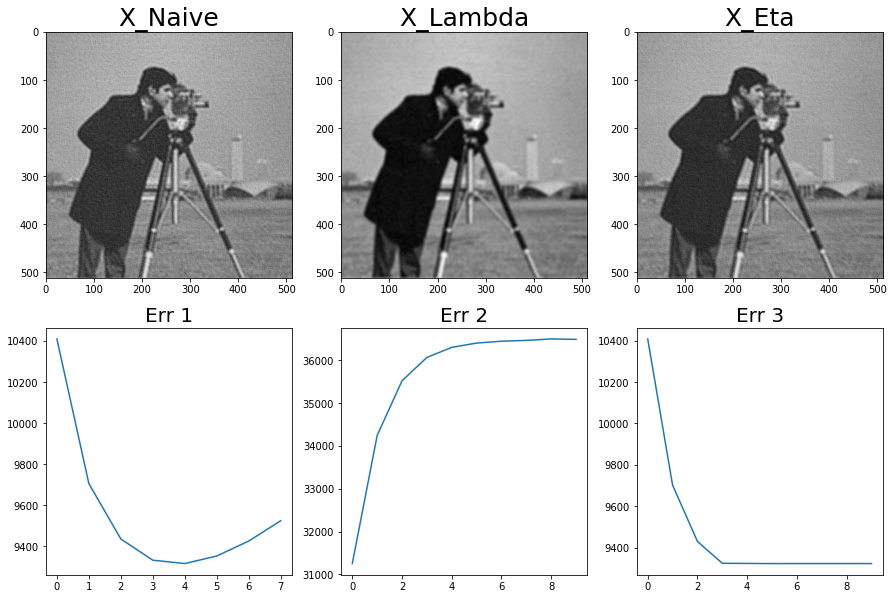

In [7]:

#Errori
err1 = np.linalg.norm(X-X_Naive, 'fro')
err2 = np.linalg.norm(X-x_lambda, 'fro')
err3 = np.linalg.norm(X-x_trunc2, 'fro')

#PSNR 
d1=psnr(X, X_Naive)
d2=psnr(X, x_lambda)
d3=psnr(X, x_trunc2)

#Mostro risultati
print('Gli errori sono:\n  X_Naive ',err1, '\n  x_lambda ', err2, '\n  x_trunc ', err3, '\n\n')
print('I valori dei PSNR sono:\n  X_Naive ',d1, '\n  x_lambda ', d2, '\n  x_trunc ', d3, '\n\n')

plt.figure(figsize=(15, 10)) 

#immagini
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(X_Naive, cmap='gray')
plt.title('X_Naive', fontsize=25)

ax2 = plt.subplot(2, 3, 2)
ax2.imshow(x_lambda, cmap='gray')
plt.title('X_Lambda', fontsize=25)

ax3 = plt.subplot(2, 3, 3)
ax3.imshow(x_trunc2, cmap='gray')
plt.title('X_Eta', fontsize=25)

#grafico Errori
ax4 = plt.subplot(2, 3, 4)
ax4.plot(err_x1, err_y1)
plt.title('Err 1', fontsize=20)

ax5 = plt.subplot(2, 3, 5)
ax5.plot(err_x2, err_y2)
plt.title('Err 2', fontsize=20)

ax6 = plt.subplot(2, 3, 6)
ax6.plot(err_x3, err_y3)

plt.title('Err 3', fontsize=20)

plt.show()

Ripetere tutti i passaggi, variando il livello del rumore (controllato dalla variabile $\sigma$), i parametri del kernel di sfocamento Gaussiano, e l'immagine di test. \\
Per la scelta delle immagini di test, utilizzare immagini **in bianco e nero, a scelta**, prese da internet, che rispettino i seguenti criteri:


*   Almeno un'immagine "geometrica", ovvero con pochi dettagli e contorni netti e ben contrastati (es. QRCode, Codice a Barre, Scacchiera...).
*   Almeno un'immagine "fotografica", ovvero con molti dettagli e livelli di grigio sfocati.
*   Almeno un'immagine contenente del testo, che diventerà difficilmente leggibile dopo il processo di sfocamento.


Osservare quale metodo di ricostruzione si comporta meglio nei vari esperimenti, ricordandosi corrompere l'immagine di input sia con rumore Gaussiano che con sfocatura.

